# Unit 5 - Financial Planning


In [1]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import numpy as np
import datetime as dt

%matplotlib inline

In [2]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [3]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [4]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [5]:
# Fetch current BTC price
btc_data = requests.get(btc_url).json()
btc_price = btc_data['data']['1']['quotes']['USD']['price']
btc_price

# Fetch current ETH price
eth_data = requests.get(eth_url).json()
eth_price = eth_data['data']['1027']['quotes']['USD']['price']
eth_price

# Compute current value of my crpto
my_btc_value = my_btc * btc_price
my_eth_value = my_eth * eth_price

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $58251.60
The current value of your 5.3 ETH is $8370.98


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [6]:
# Current amount of shares
my_agg = 200
my_spy = 50

In [7]:
# Set Alpaca API key and secret
alpaca_key = os.getenv('ALPACA_API_KEY')
alpaca_secret = os.getenv('ALPACA_SECRET_KEY')

base_url = 'https://paper-api.alpaca.markets'

# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_key,
    alpaca_secret,
    api_version='v2'
    )

In [8]:

# Format current date as ISO format
today = pd.Timestamp('2021-02-23',tz='America/New_York').isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to '1D' for Alpaca API
timeframe = "1D"

# Get current closing prices for SPY and AGG
df_portfolio = alpaca.get_barset(
    tickers, 
    timeframe,
    start = today,
    end = today
).df

# Preview DataFrame
df_portfolio

AGG                                      SPY  \
                             open    high     low   close   volume    open   
time                                                                         
2021-02-23 00:00:00-05:00  115.75  115.75  115.27  115.52  5373535  384.66   

                                                            
                              high    low  close    volume  
time                                                        
2021-02-23 00:00:00-05:00  388.945  380.2  387.5  98333278

In [9]:
# Pick AGG and SPY close prices
agg_close_price = df_portfolio['AGG'].drop(['open', 'high', 'low', 'volume'], axis = 1).rename(columns={'close':'AGG'})
spy_close_price = df_portfolio['SPY'].drop(['open', 'high', 'low', 'volume'], axis = 1).rename(columns={'close':'SPY'})
closing_prices = pd.concat([agg_close_price, spy_close_price], axis=1)

agg_close_price = closing_prices['AGG'][0]
spy_close_price = closing_prices['SPY'][0]


# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $115.52
Current SPY closing price: $387.5


In [10]:
# Compute the current value of shares
my_agg_value = my_agg * agg_close_price
my_spy_value = my_spy * spy_close_price

# Print current value of share
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $19375.00
The current value of your 200 AGG shares is $23104.00


### Savings Health Analysis

In [11]:
# Set monthly household income
monthly_income = 12000

# Create savings DataFrame
total_crpto = my_btc_value + my_eth_value
crpto_data = pd.DataFrame({'Amount': total_crpto}, index=['crpto'])

total_shares = my_agg_value + my_spy_value
shares_data = pd.DataFrame({'Amount': total_shares}, index=['shares'])

df_savings = pd.concat([crpto_data, shares_data], axis=0)

# Display savings DataFrame
df_savings

,Amount
crpto,66622.579
shares,42479.000


<AxesSubplot:title={'center':'Composition of personal savings'}, ylabel='Amount'>

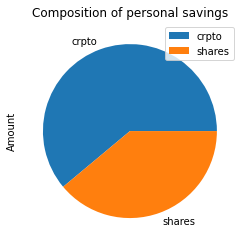

In [12]:
# Plot savings pie chart
df_savings.plot.pie(y='Amount', title='Composition of personal savings')

In [13]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = total_crpto + total_shares

# Validate saving health
if total_savings > emergency_fund:
    print('Congratulations! You have enough money in this fund.')
elif total_savings == emergency_fund:
    print('Congratulations! You are reaching this financial goal.')
else:
    print(f'You are ${emergency_fund - total_savings} away from reaching this financial goal.')

Congratulations! You have enough money in this fund.


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [14]:
# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes of 5 years from Today
date_list = [["2016-02-23"],["2021-02-23"]]

# Set the ticker information
tickers = ['SPY', 'AGG']

# Find the total number of business days
limit = np.busday_count(date_list[0][0], date_list[1][0])
limit

1305

In [15]:
# Get 5 years' worth of historical data for SPY and AGG
# Logic for data that is greater than Alpca's 1000 limit but below 2000 rows (7 year limit)
if limit > 2000:
    print("This has a 7 year limit")
elif limit> 1000:
    newend = dt.datetime.strftime((pd.to_datetime(date_list[0][0]) + pd.DateOffset(days=1000)),"%Y-%m-%d")
    date_list[0].insert(1, newend)
    newstart = dt.datetime.strftime((pd.to_datetime(date_list[0][0]) + pd.DateOffset(days=1001)),"%Y-%m-%d")
    date_list[1].insert(0, newstart)
    ticker_data = []
    # Get historical data for data greater than 1000 rows
    for i in range(2):
        data = alpaca.get_barset(
        tickers,
        timeframe,
        start = pd.Timestamp(date_list[i][0], tz="America/New_York").isoformat(),
        end = pd.Timestamp(date_list[i][1], tz="America/New_York").isoformat(),
        limit = 1000
        ).df
        ticker_data.append(data)
    all_ticker_data = pd.concat(ticker_data, axis="rows", join="inner")
    print(all_ticker_data)
else:  
    # Get historical data for data less than 1000 rows
    all_ticker_data = alpaca.get_barset(
        tickers,
        timeframe,
        start = pd.Timestamp(date_list[0][0], tz="America/New_York").isoformat(),
        end = pd.Timestamp(date_list[1][0], tz="America/New_York").isoformat(),
        limit = 1000
        ).df
    print(all_ticker_data)

                                AGG                                         \
                               open      high       low   close     volume   
time                                                                         
2016-02-23 00:00:00-05:00  109.6300  110.0000  109.5200  109.85  2148002.0   
2016-02-24 00:00:00-05:00  110.1200  110.3200  109.8400  109.89  2339276.0   
2016-02-25 00:00:00-05:00  110.0900  110.3100  110.0000  110.14  2178025.0   
2016-02-26 00:00:00-05:00  109.9000  109.9700  109.8000  109.95  1891851.0   
2016-02-29 00:00:00-05:00  109.9400  110.1000  109.9100  110.07  3467613.0   
...                             ...       ...       ...     ...        ...   
2021-02-17 00:00:00-05:00  116.2200  116.2900  116.1450  116.28  6038386.0   
2021-02-18 00:00:00-05:00  116.1400  116.2800  116.0300  116.20  3910324.0   
2021-02-19 00:00:00-05:00  116.0187  116.0600  115.7515  115.83  4416681.0   
2021-02-22 00:00:00-05:00  115.7600  115.8662  115.4800  115.49 

In [16]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_dist = MCSimulation(
    portfolio_data = all_ticker_data,
    weights = [.40, .60],
    num_simulation = 500,
    num_trading_days = 252*30
)

In [17]:
# Printing the simulation input data
MC_dist.portfolio_data.head()

AGG                                     \
                             open    high     low   close     volume   
time                                                                   
2016-02-23 00:00:00-05:00  109.63  110.00  109.52  109.85  2148002.0   
2016-02-24 00:00:00-05:00  110.12  110.32  109.84  109.89  2339276.0   
2016-02-25 00:00:00-05:00  110.09  110.31  110.00  110.14  2178025.0   
2016-02-26 00:00:00-05:00  109.90  109.97  109.80  109.95  1891851.0   
2016-02-29 00:00:00-05:00  109.94  110.10  109.91  110.07  3467613.0   

                                           SPY                          \
                          daily_return    open    high     low   close   
time                                                                     
2016-02-23 00:00:00-05:00          NaN  194.00  194.32  192.18  192.37   
2016-02-24 00:00:00-05:00     0.000364  190.63  193.53  189.32  193.22   
2016-02-25 00:00:00-05:00     0.002275  193.73  195.54  192.83  195.53   
2016-02-26 00:00:00-05:00    -0.001725  196.57  196.68  194.90  195.13   
2016-02-29 00:00:00-05:00     0.001091  195.10  196.23  193.44  193.48   

                                                   
                              volume daily_return  
time                                               
2016-02-23 00:00:00-05:00   87929515          NaN  
2016-02-24 00:00:00-05:00  119140590     0.004419  
2016-02-25 00:00:00-05:00   86360609     0.011955  
2016-02-26 00:00:00-05:00   94022841    -0.002046  
2016-02-29 00:00:00-05:00   89686326    -0.008456

In [18]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_dist.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.992783,1.005897,1.000457,0.989706,0.994346,1.007755,1.005593,0.996518,0.999175,0.998964,...,1.005444,1.010006,0.996714,0.999713,0.991926,1.003419,1.001110,0.998650,0.985742,0.997727
2,0.990755,1.006075,1.014976,0.985966,0.997753,1.008806,1.009532,0.999666,1.005816,1.001090,...,1.017639,1.016055,0.986119,1.003572,0.994191,0.999423,1.002106,1.001770,0.990520,1.007689
3,0.990374,1.009925,1.010778,0.986229,0.979108,1.010773,1.000412,1.002933,1.002167,0.996064,...,1.015863,1.006361,0.998611,0.999751,1.001835,1.017914,1.000657,0.994916,0.983558,1.015142
4,0.996408,1.002095,0.998909,0.973152,0.984612,1.011865,0.991277,1.004534,1.001057,0.997862,...,1.026841,1.003966,0.990103,1.000638,0.998617,1.018246,0.988967,0.995936,1.006826,1.007860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,23.737589,5.357826,20.230942,15.711787,18.836856,16.710608,11.393538,13.592402,14.420767,10.562906,...,25.846182,16.862962,9.929051,12.187953,18.262131,26.931642,16.680030,27.132844,53.930634,67.844554
7557,23.703921,5.352015,20.379700,15.765313,18.821897,16.303070,11.488625,13.644376,14.509558,10.581882,...,26.068499,16.782875,9.902032,12.197591,18.307574,26.991481,16.756462,27.251772,54.303654,67.800008
7558,23.687920,5.383351,20.482778,16.089868,18.900225,16.282153,11.415776,13.544817,14.610488,10.532188,...,26.166549,16.823069,9.990987,12.202350,18.166228,27.240982,17.000936,27.205613,54.888843,68.087986
7559,23.862321,5.428355,20.370047,16.032486,18.975925,16.382744,11.297789,13.688534,14.523528,10.570635,...,26.227404,16.939994,10.002772,12.174530,17.963837,27.298950,17.014057,27.310000,55.070325,67.667436


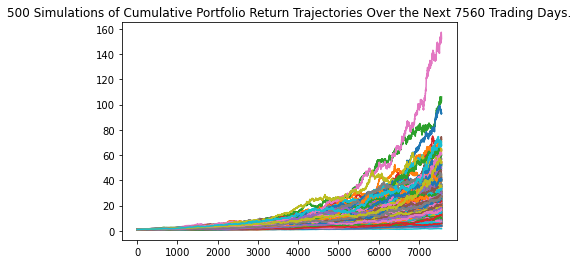

In [19]:
# Plot simulation outcomes
line_plot = MC_dist.plot_simulation()

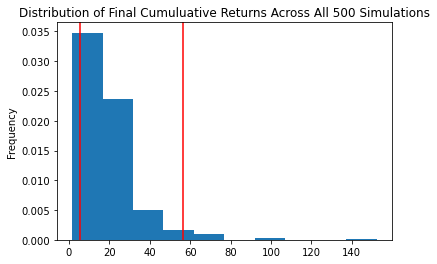

In [20]:
# Plot probability distribution and confidence intervals
dist_plot = MC_dist.plot_distribution()

### Retirement Analysis

In [21]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_mc = MC_dist.summarize_cumulative_return()

# Print summary statistic
summary_mc

count           500.000000
mean             19.542898
std              14.122504
min               1.625586
25%              11.259494
50%              16.442289
75%              22.950073
max             152.219510
95% CI Lower      5.375639
95% CI Upper     56.655695
Name: 7560, dtype: float64

### Calculate the expected portfolio return at the 95% lower and upper confidence intervals based on a `$20,000` initial investment.

In [22]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(summary_mc[8]*initial_investment,2)
ci_upper = round(summary_mc[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $107512.77 and $1133113.9


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [23]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
inc_ci_lower = round(summary_mc[8]*initial_investment,2)
inc_ci_upper = round(summary_mc[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${inc_ci_lower} and ${inc_ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $161269.16 and $1699670.84


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [24]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_dist_five = MCSimulation(
    portfolio_data = all_ticker_data,
    weights = [.40, .60],
    num_simulation = 500,
    num_trading_days = 252*5
)
MC_dist_five.portfolio_data.head()

AGG                                     \
                             open    high     low   close     volume   
time                                                                   
2016-02-23 00:00:00-05:00  109.63  110.00  109.52  109.85  2148002.0   
2016-02-24 00:00:00-05:00  110.12  110.32  109.84  109.89  2339276.0   
2016-02-25 00:00:00-05:00  110.09  110.31  110.00  110.14  2178025.0   
2016-02-26 00:00:00-05:00  109.90  109.97  109.80  109.95  1891851.0   
2016-02-29 00:00:00-05:00  109.94  110.10  109.91  110.07  3467613.0   

                                           SPY                          \
                          daily_return    open    high     low   close   
time                                                                     
2016-02-23 00:00:00-05:00          NaN  194.00  194.32  192.18  192.37   
2016-02-24 00:00:00-05:00     0.000364  190.63  193.53  189.32  193.22   
2016-02-25 00:00:00-05:00     0.002275  193.73  195.54  192.83  195.53   
2016-02-26 00:00:00-05:00    -0.001725  196.57  196.68  194.90  195.13   
2016-02-29 00:00:00-05:00     0.001091  195.10  196.23  193.44  193.48   

                                                   
                              volume daily_return  
time                                               
2016-02-23 00:00:00-05:00   87929515          NaN  
2016-02-24 00:00:00-05:00  119140590     0.004419  
2016-02-25 00:00:00-05:00   86360609     0.011955  
2016-02-26 00:00:00-05:00   94022841    -0.002046  
2016-02-29 00:00:00-05:00   89686326    -0.008456

In [25]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_dist_five.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.995412,1.010071,0.988950,1.004145,0.994299,1.002113,1.003464,1.002969,1.000516,1.003328,...,0.992804,1.011155,1.009581,1.016064,0.996598,1.013214,1.003689,1.005813,1.001707,1.011852
2,0.998813,1.013884,0.991158,1.015368,0.999598,1.009572,1.004967,1.010686,1.010241,1.006098,...,0.986057,1.021200,1.011852,1.024757,1.002689,1.024767,0.988961,1.000001,1.001301,1.008269
3,1.007535,1.002511,0.980783,1.015048,1.001883,1.012443,1.009509,0.999645,1.007159,1.012909,...,0.990145,1.011496,1.024731,1.018714,1.005191,1.020600,0.987059,0.996394,1.007346,1.023006
4,1.017513,1.004648,0.981622,1.009416,1.006652,1.000937,1.010366,1.004973,1.007656,1.012183,...,0.990317,1.015730,1.014014,1.024749,1.012241,1.020324,0.992204,1.011274,1.013817,1.025991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,2.457485,1.771642,1.201787,1.487968,1.574849,2.345513,1.207818,2.321450,2.065304,1.289966,...,1.820994,2.056936,1.259911,2.087356,1.112375,1.122981,1.171857,1.738233,2.032336,1.184268
1257,2.451985,1.769787,1.197859,1.484790,1.576563,2.365497,1.216624,2.295088,2.080924,1.312046,...,1.830732,2.039688,1.248404,2.074867,1.099292,1.136744,1.161587,1.725707,2.033806,1.185168
1258,2.454482,1.769911,1.194445,1.477066,1.575422,2.364597,1.209510,2.290393,2.076897,1.310510,...,1.825444,2.038953,1.250651,2.068430,1.112272,1.133373,1.177572,1.740985,2.010992,1.196397
1259,2.441372,1.772990,1.188154,1.479334,1.600531,2.381678,1.203400,2.274164,2.092862,1.306035,...,1.850346,2.057415,1.249439,2.067381,1.111605,1.129754,1.177774,1.761472,1.994066,1.191416


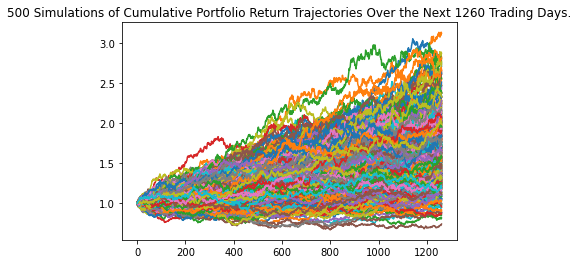

In [26]:
# Plot simulation outcomes
line_plot_five = MC_dist_five.plot_simulation()

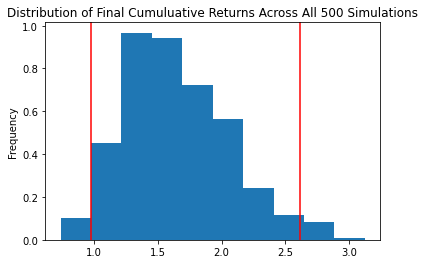

In [ ]:
# Plot probability distribution and confidence intervals
dist_plot_five = MC_dist_five.plot_distribution()

In [ ]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_mc_five = MC_dist_five.summarize_cumulative_return()

# Print summary statistics
summary_mc_five

count           500.000000
mean              1.651148
std               0.412348
min               0.742056
25%               1.335670
50%               1.597704
75%               1.914137
max               3.120355
95% CI Lower      0.982491
95% CI Upper      2.610953
Name: 1260, dtype: float64

In [ ]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five = round(summary_mc_five[8]*initial_investment,2)
ci_upper_five = round(summary_mc_five[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 5 years will end within in the range of $19649.81 and $52219.06


### Ten Years Retirement Option

In [ ]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
MC_dist_ten = MCSimulation(
    portfolio_data = all_ticker_data,
    weights = [.40, .60],
    num_simulation = 500,
    num_trading_days = 252*10
)
MC_dist_five.portfolio_data.head()

AGG                                     \
                             open    high     low   close     volume   
time                                                                   
2016-02-23 00:00:00-05:00  109.63  110.00  109.52  109.85  2148002.0   
2016-02-24 00:00:00-05:00  110.12  110.32  109.84  109.89  2339276.0   
2016-02-25 00:00:00-05:00  110.09  110.31  110.00  110.14  2178025.0   
2016-02-26 00:00:00-05:00  109.90  109.97  109.80  109.95  1891851.0   
2016-02-29 00:00:00-05:00  109.94  110.10  109.91  110.07  3467613.0   

                                           SPY                          \
                          daily_return    open    high     low   close   
time                                                                     
2016-02-23 00:00:00-05:00          NaN  194.00  194.32  192.18  192.37   
2016-02-24 00:00:00-05:00     0.000364  190.63  193.53  189.32  193.22   
2016-02-25 00:00:00-05:00     0.002275  193.73  195.54  192.83  195.53   
2016-02-26 00:00:00-05:00    -0.001725  196.57  196.68  194.90  195.13   
2016-02-29 00:00:00-05:00     0.001091  195.10  196.23  193.44  193.48   

                                                   
                              volume daily_return  
time                                               
2016-02-23 00:00:00-05:00   87929515          NaN  
2016-02-24 00:00:00-05:00  119140590     0.004419  
2016-02-25 00:00:00-05:00   86360609     0.011955  
2016-02-26 00:00:00-05:00   94022841    -0.002046  
2016-02-29 00:00:00-05:00   89686326    -0.008456

In [ ]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_dist_ten.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.004284,1.015166,1.000661,1.016746,0.977837,1.009335,1.005599,1.001569,1.013716,0.999051,...,1.003686,0.997227,0.993112,0.992162,0.979948,1.005344,1.001410,1.003035,1.007388,0.999654
2,1.014568,1.020810,0.989614,1.017453,0.977758,1.018238,1.017502,1.014604,1.004869,0.998199,...,0.989028,0.990769,0.998814,0.996187,0.988570,0.998322,0.996922,0.991743,1.021997,0.989410
3,1.008644,1.020207,0.981379,1.026868,0.980849,1.004734,1.016015,1.023899,1.011508,1.002790,...,0.990114,0.987435,1.000696,0.977865,0.985577,1.008297,0.983982,0.992395,1.007825,0.995848
4,1.003404,1.017219,0.990772,1.029977,0.987099,0.996700,1.000540,1.035690,1.008139,1.001494,...,0.981478,0.984474,1.013808,0.982296,0.969775,1.012416,0.973491,0.985949,1.010200,1.004586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,3.623156,2.640530,1.690542,2.063952,1.654204,2.179493,2.163222,3.152035,1.487374,4.010710,...,2.581899,3.493442,5.718996,3.443561,2.271662,2.249919,2.579414,4.063808,1.981395,1.939305
2517,3.602126,2.649390,1.667214,2.033405,1.653077,2.190283,2.172721,3.114404,1.491330,4.040543,...,2.601299,3.471261,5.683654,3.445184,2.279132,2.255370,2.574567,4.033187,2.009123,1.944371
2518,3.603438,2.638794,1.664150,2.022476,1.659504,2.175578,2.164678,3.120519,1.511605,4.010217,...,2.620193,3.490730,5.662933,3.503337,2.255169,2.234893,2.552403,4.056735,2.036304,1.951827
2519,3.631865,2.618586,1.679972,2.021805,1.664871,2.152175,2.162398,3.121549,1.519119,4.001878,...,2.634641,3.486635,5.692962,3.494812,2.245157,2.210536,2.558605,4.109125,2.058750,1.962165


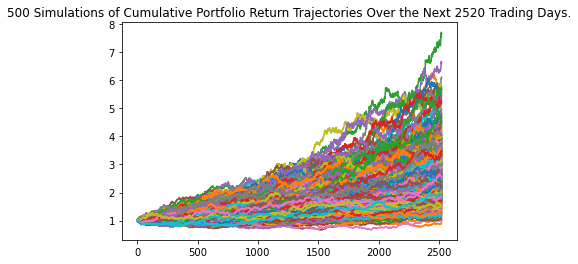

In [ ]:
# Plot simulation outcomes
line_plot_ten = MC_dist_ten.plot_simulation()

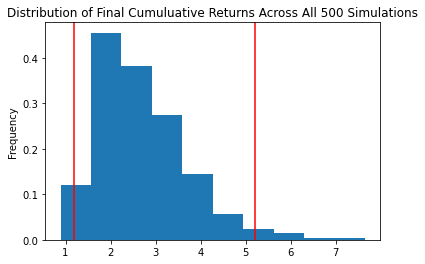

In [ ]:
# Plot probability distribution and confidence intervals
dist_plot_ten = MC_dist_ten.plot_distribution()

In [ ]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_mc_ten = MC_dist_ten.summarize_cumulative_return()

# Print summary statistics
summary_mc_ten

count           500.000000
mean              2.689762
std               0.998469
min               0.889128
25%               1.966745
50%               2.498215
75%               3.275373
max               7.647130
95% CI Lower      1.198081
95% CI Upper      5.204579
Name: 2520, dtype: float64

In [ ]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_ten = round(summary_mc_ten[8]*initial_investment,2)
ci_upper_ten = round(summary_mc_ten[9]*initial_investment,2)
# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 10 years will end within in the range of $23961.61 and $104091.58
